Install the dataset


In [49]:
!pip install CocoDataset==0.1.2

we build the data with https://www.tensorflow.org/datasets/api_docs/python/tfds/folder_dataset/ImageFolder, 

tfds.folder_dataset.ImageFolder, needs to have an specific stracture. (check the documentation)


Now, we create the stracture, but befire we need to mount the drive from left side panel-> files -> click mount drive

In [70]:
!pwd

/content/drive/MyDrive/coco_data/train


mount the drive and select the directory

first, we set the training directory

In [69]:
cd /content/drive/MyDrive/coco_data/train


/content/drive/MyDrive/coco_data/train


Download the annotations

In [65]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip /content/drive/MyDrive/coco_data/test/annotations_trainval2014.zip





--2022-03-13 21:19:05--  http://images.cocodataset.org/annotations/annotations_trainval2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.86.20
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.86.20|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252872794 (241M) [application/zip]
Saving to: ‘annotations_trainval2014.zip’

annotations_trainva 100%[===================>] 241.16M  33.5MB/s    in 7.0s    

2022-03-13 21:19:12 (34.6 MB/s) - ‘annotations_trainval2014.zip’ saved [252872794/252872794]

Archive:  /content/drive/MyDrive/coco_data/test/annotations_trainval2014.zip
  inflating: annotations/instances_train2014.json  
  inflating: annotations/instances_val2014.json  
  inflating: annotations/person_keypoints_train2014.json  
  inflating: annotations/person_keypoints_val2014.json  
  inflating: annotations/captions_train2014.json  
  inflating: annotations/captions_val2014.json  


class names for downloading


In [56]:
classes = ['airplane', "apple", "banana", "boat", "bus", "car","person","bicycle","bird","book"]

write the function to download the class with annotations and save it to content folder

In [66]:
from coco_dataset import coco_dataset_download as cocod


def manual_download(names):
  class_name=names  #class name example 
  images_count=15       #count of images  
  annotations_path='/content/drive/MyDrive/coco_data/test/annotations/instances_train2014.json' #path of coco dataset annotations 
  #call download function 
  cocod.coco_dataset_download(class_name,images_count,annotations_path)





In [ ]:
for i in classes:
  manual_download(i)
  

In [ ]:
# for removing the annotations
!rm -rf annotations

Now we set the test directory and download the daata these

In [ ]:
cd /content/drive/MyDrive/coco_data/test

In [ ]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip /content/drive/MyDrive/coco_data/test/annotations_trainval2014.zip





In [ ]:
from coco_dataset import coco_dataset_download as cocod


def manual_download(names):
  class_name=names  #class name example 
  images_count=15       #count of images  
  annotations_path='/content/drive/MyDrive/coco_data/test/annotations/instances_val2014.json' #path of coco dataset annotations 
  #call download function 
  cocod.coco_dataset_download(class_name,images_count,annotations_path)


In [ ]:
for i in classes:
  manual_download(i)

In [ ]:
# for removing the annotations
!rm -rf annotations

now we build the data from folder as tensors


In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

builder = tfds.ImageFolder('/content/drive/MyDrive/coco_data/')
print(builder.info)  # num examples, labels... are automatically calculated
dataset = builder.as_dataset(shuffle_files=True, as_supervised = True)
train_ds, test_ds = dataset["train"], dataset["test"]

tfds.core.DatasetInfo(
    name='image_folder',
    version=1.0.0,
    description='Generic image classification dataset.',
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=11),
    }),
    total_num_examples=1170,
    splits={
        'test': 160,
        'train': 1010,
    },
    supervised_keys=('image', 'label'),
    citation="""""",
    redistribution_info=,
)



to preprocess the data pipeline

In [3]:

import numpy as np


def prepare_coco_data(mnist):
  #flatten the images into vectors
  mnist = mnist.map(lambda img, target: (tf.image.resize(img, [64,64],
                                         method = tf.image.ResizeMethod.BILINEAR, 
                                         preserve_aspect_ratio=False),      target))
  
  #convert data from uint8 to float32
  mnist = mnist.map(lambda img, target: (tf.cast(img, tf.float32), target))
  #sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1]
  mnist = mnist.map(lambda img, target: ((img/128.)-1., target))
  #create one-hot targets
  mnist = mnist.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
  #cache this progress in memory, as there is no need to redo it; it is deterministic after all
  mnist = mnist.cache()
  #shuffle, batch, prefetch
  mnist = mnist.shuffle(1000)
  mnist = mnist.batch(32)
  mnist = mnist.prefetch(20)
  #return preprocessed dataset
  return mnist

train_dataset = train_ds.apply(prepare_coco_data)
test_dataset = test_ds.apply(prepare_coco_data)

build the model(demo, just to test the data)

In [4]:
from tensorflow.keras.layers import Dense


class MyModel(tf.keras.Model):
    
    def __init__(self):
        super(MyModel, self).__init__() # input 128 x 128 x 3
        self.conv_1 = tf.keras.layers.Conv2D(filters=36, kernel_size=(2,2), strides=(2, 2),activation=tf.nn.relu) # 64x 64x 36
        self.max_pool = tf.keras.layers.MaxPool2D(pool_size=(2,2) ,strides=(2, 2))# 32 x 32 x 36
        # self.dense1 = tf.keras.layers.conv2D(filters=36, kernel_size=(2,2), strides=(2, 2), padding="valid",activation=tf.nn.relu)
        self.conv_2 = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), strides=(1, 1),activation=tf.nn.relu) # 30 x 30 x 16

        self.flatten = tf.keras.layers.GlobalAveragePooling2D()
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)
        

    @tf.function
    def call(self, inputs):
        x = self.conv_1(inputs)
        x = self.max_pool(x)
        x = self.conv_2(x)
        x = self.flatten(x)
        x = self.out(x)
        return x
    

train steps, takem from complete model train file

In [5]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [20]:
tf.keras.backend.clear_session()

#For showcasing we only use a subset of the training and test data (generally use all of the available data!)
train_dataset = train_dataset.take(100)
test_dataset = test_dataset.take(10)

### Hyperparameters
num_epochs = 50
learning_rate = 0.0001

# Initialize the model.
model = MyModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    #training (and checking in with training)
    epoch_loss_agg = []
    for input,target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
    
    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: 0 starting with accuracy 0.11875
Epoch: 1 starting with accuracy 0.11875
Epoch: 2 starting with accuracy 0.11875
Epoch: 3 starting with accuracy 0.11875
Epoch: 4 starting with accuracy 0.1125
Epoch: 5 starting with accuracy 0.10625
Epoch: 6 starting with accuracy 0.10625
Epoch: 7 starting with accuracy 0.10625
Epoch: 8 starting with accuracy 0.10625
Epoch: 9 starting with accuracy 0.10625
Epoch: 10 starting with accuracy 0.11875
Epoch: 11 starting with accuracy 0.11875
Epoch: 12 starting with accuracy 0.11875
Epoch: 13 starting with accuracy 0.11875
Epoch: 14 starting with accuracy 0.125
Epoch: 15 starting with accuracy 0.11875
Epoch: 16 starting with accuracy 0.11875
Epoch: 17 starting with accuracy 0.11875
Epoch: 18 starting with accuracy 0.1125
Epoch: 19 starting with accuracy 0.1125
Epoch: 20 starting with accuracy 0.1125
Epoch: 21 starting with accuracy 0.1125
Epoch: 22 starting with accuracy 0.1125
Epoch: 23 starting with accuracy 0.1125
Epoch: 24 starting with accuracy 0.

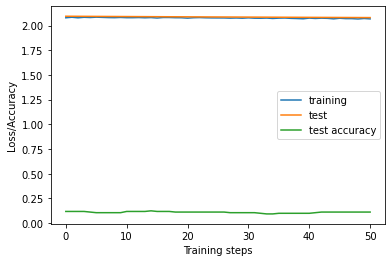

In [21]:
import matplotlib.pyplot as plt

# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2, line3),("training","test", "test accuracy"))
plt.show()